In [1]:
!pip install transformers

In [2]:
import os
import time
import datetime

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt


import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [41]:
# Input data
file_path = '/kaggle/input/preprocessed-data/data_preprocessed.csv'
data = pd.read_csv(file_path)
print(data.head(20))

     ProductId  HelpfulnessNumerator  HelpfulnessDenominator  Score  \
0   B001E4KFG0                     1                       1      5   
1   B00813GRG4                     0                       0      1   
2   B000LQOCH0                     1                       1      4   
3   B000UA0QIQ                     3                       3      2   
4   B006K2ZZ7K                     0                       0      4   
5   B006K2ZZ7K                     0                       0      5   
6   B006K2ZZ7K                     0                       0      5   
7   B000E7L2R4                     1                       1      5   
8   B00171APVA                     0                       0      5   
9   B0001PB9FE                     1                       1      5   
10  B0009XLVG0                     4                       4      5   
11  B0009XLVG0                     1                       1      1   
12  B001GVISJM                     2                       2      4   
13  B0

In [42]:
text_all = data.Text.copy() #just use the main text in this example
text_all

0         I have bought several of the Vitality canned d...
1         Product arrived labeled as Jumbo Salted Peanut...
2         This is a confection that has been around a fe...
3         If you are looking for the secret ingredient i...
4         I got a wild hair for taffy and ordered this f...
                                ...                        
538158    Great for sesame chicken..this is a good if no...
538159    I'm disappointed with the flavor. The chocolat...
538160    These stars are small, so you can give 10-15 o...
538161    These are the BEST treats for training and rew...
538162    I am very satisfied ,product is as advertised,...
Name: Text, Length: 538163, dtype: object

In [5]:
# Generate a random sample of 700 cases
texts = text_all.sample(n=100, random_state=1)
texts

324919    This stuff is great. The cats love it ( all fl...
391045    This is my second experience with microwaved w...
320084    All of my cats adore these treats. One cat in ...
267651    Amish Kitchens Extra-Thick Kluski Egg Noodles ...
16396     Great price for 240 pieces in total. It's swee...
                                ...                        
79765     I've eaten it with seafood (shrimp, tuna, or s...
361477    These gluten-free chocolate chip cookies come ...
61389     Ordered over $1,000 worth of can goods for dis...
505926    This cereal is fantastic.  The taste of the ce...
78699     Robust, full-bodied and delightful. If you lik...
Name: Text, Length: 100, dtype: object

We need to get an idea of how long our training documents are.
I'm not going to use the same tokenizer as the GPT2 one, which is a byte pair encoding tokenizer. Instead, I'm using a simple one just to get a rough understanding.

/tmp/ipykernel_34/2653391606.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(doc_lengths)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Density'>

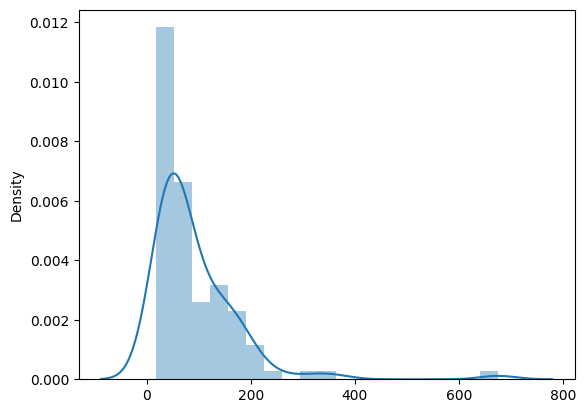

In [6]:
doc_lengths = []

for text in texts:

    # get rough token count distribution
    tokens = nltk.word_tokenize(text)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.distplot(doc_lengths)

In [7]:
# the max token length   
len(doc_lengths[doc_lengths > 768])/len(doc_lengths)

0.0

In [8]:
np.average(doc_lengths)

92.84

Even though these token counts won't match up to the BPE tokenizer's, I'm confident that most bios will be fit under the 768 embedding size limit for the small GPT2 model.

# GPT2 Tokenizer

In [9]:
# Load the GPT tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium

print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50258


In [10]:
class TextDataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=768):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer(tokenizer.bos_token + txt + tokenizer.eos_token, truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 



In [44]:
import torch
from torch.utils.data import Dataset

class TextDataset(Dataset):
    def __init__(self, txt_list, tokenizer, max_length=768):
        self.tokenizer = tokenizer
        self.input_ids = []
        self.attn_masks = []

        # Batch tokenize the entire list of texts
        encodings = tokenizer(
            [tokenizer.bos_token + txt + tokenizer.eos_token for txt in txt_list],
            truncation=True,
            max_length=max_length,
            padding="max_length",
            return_tensors="pt"
        )

        self.input_ids = encodings['input_ids']
        self.attn_masks = encodings['attention_mask']
    
    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.attn_masks[idx] 


In [ ]:
def fine_tune_gpt2(model_name, train_data, output_dir):
    training_stats = []
    # Set the seed value all over the place to make this reproducible.
    seed_val = 42

    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)
   
    # Load GPT-2 model and tokenizer
    tokenizer = GPT2Tokenizer.from_pretrained(model_name, bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') 
    model = GPT2LMHeadModel.from_pretrained(model_name)
    model.resize_token_embeddings(len(tokenizer))

    # Load training dataset
    train_dataset = TextDataset(
        tokenizer=tokenizer,
        txt_list = train_data,
        max_length=768
    )

    # Create data loader
    train_dataloader = DataLoader(
        train_dataset,
        sampler=RandomSampler(train_dataset),
        batch_size=2
    )

    # Set up optimizer and learning rate scheduler
    optimizer = AdamW(model.parameters(), lr=5e-4, eps=1e-8)
    
    
    
    total_steps = len(train_dataloader) * 5  # 5 epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=1e2,
        num_training_steps=total_steps
    )

    # Move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Training loop
    
    model.train()
    for epoch in range(5):  # num_train_epochs
        epoch_iterator = tqdm(train_dataloader, desc=f"Epoch {epoch+1}")
        batch_loss = 0
        for step, batch in enumerate(epoch_iterator):
                       
            inputs, attention_masks = batch
            inputs = inputs.to(device)
            attention_masks = attention_masks.to(device)

            outputs = model(inputs, attention_mask=attention_masks, labels=inputs)
            
            loss = outputs.loss
            batch_loss += loss.item()
            loss.backward()

            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            
        avg_train_loss = loss/len(train_dataloader)
        training_stats.append(
        {
            'epoch': epoch+1,
            'Training Loss': avg_train_loss,
            #'Valid. Loss': avg_val_loss,
            #'Training Time': training_time,
            #'Validation Time': validation_time
        }
    )

    # Save the fine-tuned model
    model.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)
    return training_stats

# Uncomment the following line to run the function
training_stats = fine_tune_gpt2('gpt2', train_data=text_all, output_dir="/kaggle/working/")

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1:   6%|▌         | 15216/269082 [2:04:09<34:50:48,  2.02it/s]

In [32]:
pd.set_option('display.precision', 2)
df = pd.DataFrame(training_stats)
df

,epoch,Training Loss
0,1,"tensor(0.3442, device='cuda:0', grad_fn=<DivBa..."
1,2,"tensor(0.0062, device='cuda:0', grad_fn=<DivBa..."
2,3,"tensor(0.0059, device='cuda:0', grad_fn=<DivBa..."
3,4,"tensor(0.0054, device='cuda:0', grad_fn=<DivBa..."
4,5,"tensor(0.0054, device='cuda:0', grad_fn=<DivBa..."


In [33]:
plt.plot(df['epoch'], df['Training Loss'])
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


KeyError: 'avg_train_loss'

# Display Model Info

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

# Saving & Loading Fine-Tuned Model

In [ ]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
torch.save(args, os.path.join(output_dir, 'training_args.bin'))

# Generate Text

In [ ]:
#Load a trained model and vocabulary that you have fine-tuned
model = GPT2LMHeadModel.from_pretrained(output_dir)
tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
model.to(device)

In [ ]:
model.eval()

prompt = "<|startoftext|> What do you think about books?"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated, 
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,   
                                top_k=50, 
                                max_length = 300,
                                top_p=0.95, 
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))